<a href="https://colab.research.google.com/github/Ak4nksha/ai-generated-text-detector/blob/main/notebooks/03_feature_engineering_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q textstat spacy tqdm
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 137.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import textstat
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas()  # enable progress bar on apply

# load lightweight spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
CSV_PATH = "/content/drive/MyDrive/final_merged_dataset.csv"

df = pd.read_csv(CSV_PATH, engine="python", escapechar='\\',on_bad_lines='skip')
print("Columns:", df.columns)
print(len(df))
df.head()

Columns: Index(['text', 'label', 'doc_id', 'source'], dtype='object')
505213


,text,label,doc_id,source
0,Wlectoral College is a process that help the U...,0,NaN,NaN
1,"Dear Principal Johnson, I AP writing to expres...",1,NaN,NaN
2,"In the article, the author suggests studying c...",0,NaN,NaN
3,The usage of motor vehicles has been on a stea...,0,NaN,NaN
4,Sold 30 items on Vinted? Don't panic if you ge...,0,news_a6e189b87355,news


Columns: Index(['text', 'label', 'doc_id', 'source'], dtype='object')
First few rows:


,text,label,doc_id,source
0,Wlectoral College is a process that help the U...,0,kaggle_0,kaggle
1,"Dear Principal Johnson, I AP writing to expres...",1,kaggle_1,kaggle
2,"In the article, the author suggests studying c...",0,kaggle_2,kaggle
3,The usage of motor vehicles has been on a stea...,0,kaggle_3,kaggle
4,Sold 30 items on Vinted? Don't panic if you ge...,0,news_a6e189b87355,news



Dataset shape: (505213, 4)

Label value counts:
label
0    311675
1    193538
Name: count, dtype: int64


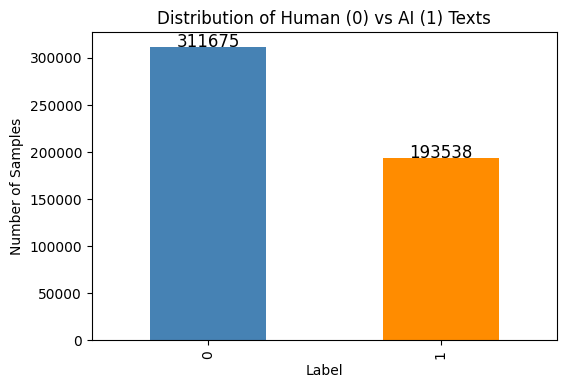

In [8]:
CSV_PATH = "/content/drive/MyDrive/final_merged_dataset.csv"
TEXT_COL = "text"
LABEL_COL = "label"

# Robust CSV load (handles quotes, bad lines)
df = pd.read_csv(
    CSV_PATH,
    engine="python",
    escapechar="\\",
    on_bad_lines="skip"
)

# Drop rows with missing text/label
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# Clean label column: ensure numeric 0/1
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")
df[LABEL_COL] = df[LABEL_COL].fillna(0).astype(int)

#additional fixes for NAN values
df["source"] = df["source"].fillna("kaggle")
nan_rows = df['doc_id'].isna()
df.loc[nan_rows, 'doc_id'] = "kaggle_" + df.loc[nan_rows].index.astype(str)


print("Columns:", df.columns)
print("First few rows:")
display(df.head())
print(f"\nDataset shape: {df.shape}")

print("\nLabel value counts:")
# Count class distribution
counts = df[LABEL_COL].value_counts().sort_index()
print(counts)


import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title("Distribution of Human (0) vs AI (1) Texts")
plt.xlabel("Label")
plt.ylabel("Number of Samples")

# Annotate bars with counts
for i, v in enumerate(counts):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12)

plt.show()

In [9]:
def basic_counts(text: str):
    text = text or ""
    num_chars = len(text)

    # sentence split
    sentences = re.split(r"[.!?]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]
    num_sent = len(sentences) if sentences else 1

    # word tokens
    words = re.findall(r"\w+", text)
    num_words = len(words) if words else 1

    avg_sent_len = num_words / num_sent
    return {
        "num_chars": num_chars,
        "num_words": num_words,
        "num_sentences": num_sent,
        "avg_sentence_length": avg_sent_len,
    }


def lexical_diversity(text: str):
    words = re.findall(r"\w+", str(text).lower())
    if not words:
        return {
            "type_token_ratio": 0.0,
            "unique_words": 0,
        }
    unique = set(words)
    ttr = len(unique) / len(words)
    return {
        "type_token_ratio": ttr,
        "unique_words": len(unique),
    }


def punctuation_stats(text: str):
    text = text or ""
    if not text:
        return {
            "pct_punct": 0.0,
            "pct_upper": 0.0,
            "pct_digit": 0.0,
        }
    total = len(text)
    punct = sum(ch in string.punctuation for ch in text)
    upper = sum(ch.isupper() for ch in text)
    digit = sum(ch.isdigit() for ch in text)
    return {
        "pct_punct": punct / total,
        "pct_upper": upper / total,
        "pct_digit": digit / total,
    }


def readability_features(text: str):
    clean = text if isinstance(text, str) else ""
    if len(clean.split()) < 3:
        return {
            "flesch_reading_ease": 0.0,
            "flesch_kincaid_grade": 0.0,
            "gunning_fog": 0.0,
        }
    try:
        fre = textstat.flesch_reading_ease(clean)
        fkg = textstat.flesch_kincaid_grade(clean)
        gf  = textstat.gunning_fog(clean)
    except Exception:
        fre, fkg, gf = 0.0, 0.0, 0.0
    return {
        "flesch_reading_ease": fre,
        "flesch_kincaid_grade": fkg,
        "gunning_fog": gf,
    }


def repetition_features(text: str):
    tokens = re.findall(r"\w+", str(text).lower())
    if len(tokens) < 4:
        return {"bigram_repetition_ratio": 0.0}
    bigrams = list(zip(tokens, tokens[1:]))
    total_bigrams = len(bigrams)
    counts = Counter(bigrams)
    repeated = sum(c for c in counts.values() if c > 1)
    return {
        "bigram_repetition_ratio": repeated / total_bigrams
    }


def pos_features_spacy(text: str):
    doc = nlp(str(text))
    tokens = [t for t in doc if not t.is_space]
    total_tokens = len(tokens)
    if total_tokens == 0:
        return {
            "pos_ratio_NOUN": 0.0,
            "pos_ratio_VERB": 0.0,
            "pos_ratio_ADJ": 0.0,
            "pos_ratio_ADV": 0.0,
            "pos_ratio_PRON": 0.0,
            "pos_ratio_ADP": 0.0,
            "pos_ratio_DET": 0.0,
        }
    counts = Counter(tok.pos_ for tok in tokens)

    def ratio(tag):
        return counts.get(tag, 0) / total_tokens

    return {
        "pos_ratio_NOUN": ratio("NOUN"),
        "pos_ratio_VERB": ratio("VERB"),
        "pos_ratio_ADJ":  ratio("ADJ"),
        "pos_ratio_ADV":  ratio("ADV"),
        "pos_ratio_PRON": ratio("PRON"),
        "pos_ratio_ADP":  ratio("ADP"),
        "pos_ratio_DET":  ratio("DET"),
    }


def sentence_length_stats(text: str):
    sentences = re.split(r"[.!?]+", str(text))
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 2:
        return {
            "sentence_length_std": 0.0,
            "sentence_length_mean": len(str(text).split()),
        }
    lens = [len(s.split()) for s in sentences]
    return {
        "sentence_length_std": float(np.std(lens)),
        "sentence_length_mean": float(np.mean(lens)),
    }


def compute_all_features(text: str):
    feats = {}
    feats.update(basic_counts(text))
    feats.update(lexical_diversity(text))
    feats.update(punctuation_stats(text))
    feats.update(readability_features(text))
    feats.update(repetition_features(text))
    feats.update(pos_features_spacy(text))
    feats.update(sentence_length_stats(text))
    return feats

In [10]:
print("Computing features for each text")

features_series = df[TEXT_COL].progress_apply(compute_all_features)
features_df = pd.DataFrame(list(features_series))

print("New feature columns:", features_df.columns.tolist())

df_aug = pd.concat(
    [df.reset_index(drop=True), features_df.reset_index(drop=True)],
    axis=1
)

print("\nAugmented dataframe shape:", df_aug.shape)
df_aug.head()

Computing features for each text


  0%|          | 0/505213 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_df, temp_df = train_test_split(
    df_aug,
    test_size=0.3,
    stratify=df_aug[LABEL_COL],
    random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df[LABEL_COL],
    random_state=RANDOM_SEED
)

print(len(train_df), len(val_df), len(test_df))

23625 5062 5063


In [ ]:
# ---- Check that there is no overlap between train/val/test ----
train_idx = set(train_df.index)
val_idx   = set(val_df.index)
test_idx  = set(test_df.index)

print("Overlap train ∩ val:", len(train_idx & val_idx))
print("Overlap train ∩ test:", len(train_idx & test_idx))
print("Overlap val ∩ test:", len(val_idx & test_idx))

assert len(train_idx & val_idx) == 0, "Train and val sets overlap!"
assert len(train_idx & test_idx) == 0, "Train and test sets overlap!"
assert len(val_idx & test_idx) == 0, "Val and test sets overlap!"

print("\n✅ No index overlap between train, val, and test.")


Overlap train ∩ val: 0
Overlap train ∩ test: 0
Overlap val ∩ test: 0

✅ No index overlap between train, val, and test.


In [ ]:
numeric_cols = [
    c for c in df_aug.columns
    if c not in [TEXT_COL, LABEL_COL]
]

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(
            max_features=20000,
            ngram_range=(1,3),
            sublinear_tf=True
        ), TEXT_COL),
        ("num", StandardScaler(), numeric_cols),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

print("Training model...")
clf.fit(train_df, train_df[LABEL_COL])

val_pred = clf.predict(val_df)
test_pred = clf.predict(test_df)

print("\n=== VALIDATION REPORT ===")
print(classification_report(val_df[LABEL_COL], val_pred, digits=4))

print("\n=== TEST REPORT ===")
print(classification_report(test_df[LABEL_COL], test_pred, digits=4))

Training model...

=== VALIDATION REPORT ===
              precision    recall  f1-score   support

           0     0.9864    0.9909    0.9886      2414
           1     0.9917    0.9875    0.9896      2648

    accuracy                         0.9891      5062
   macro avg     0.9890    0.9892    0.9891      5062
weighted avg     0.9891    0.9891    0.9891      5062


=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.9860    0.9917    0.9888      2414
           1     0.9924    0.9872    0.9898      2649

    accuracy                         0.9893      5063
   macro avg     0.9892    0.9894    0.9893      5063
weighted avg     0.9894    0.9893    0.9893      5063



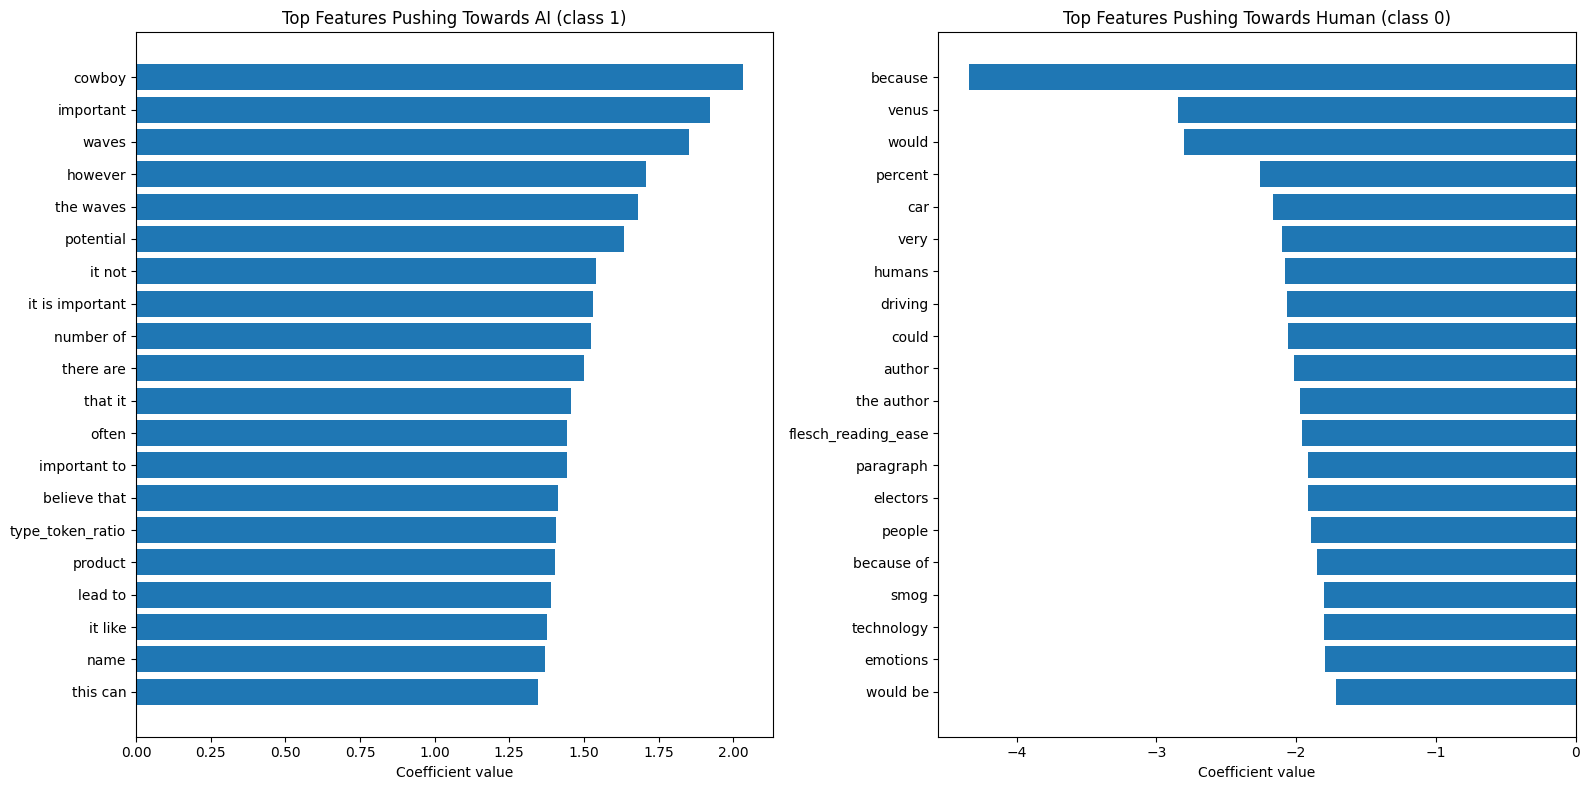

(                feature      coef
 4214             cowboy  2.031840
 7745          important  1.922974
 18777             waves  1.850108
 7527            however  1.708766
 16324         the waves  1.679373
 12590         potential  1.632676
 8850             it not  1.539147
 8802    it is important  1.530372
 10765         number of  1.523081
 16553         there are  1.498570
 15226           that it  1.457135
 11292             often  1.442077
 7762       important to  1.441962
 2437       believe that  1.411799
 20004  type_token_ratio  1.406198
 12802           product  1.401751
 9205            lead to  1.390096
 8828            it like  1.377152
 10391              name  1.370248
 16882          this can  1.346564,
        feature      coef
 2268   because -4.343380
 18399    venus -2.842977
 19620    would -2.799809
 12206  percent -2.262259
 3182       car -2.168099)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Extract feature names from the pipeline ----
logreg = clf.named_steps["logreg"]
preproc = clf.named_steps["preprocess"]

# TF-IDF feature names
tfidf = preproc.named_transformers_["tfidf"]
tfidf_features = tfidf.get_feature_names_out()

# Numeric feature names (we already have numeric_cols list)
num_features = np.array(numeric_cols)

# Concatenate all feature names in the same order as the transformed matrix
all_feature_names = np.concatenate([tfidf_features, num_features])

# Logistic regression coefficients for class 1 (binary: shape = (1, n_features))
coefs = logreg.coef_[0]

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs
})

# ---- Top 20 positive (AI indicators) & Top 20 negative (Human indicators) ----
top_pos = coef_df.nlargest(20, "coef")   # pushes towards class 1 (AI)
top_neg = coef_df.nsmallest(20, "coef") # pushes towards class 0 (Human)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive coefficients (AI)
axes[0].barh(top_pos["feature"], top_pos["coef"])
axes[0].set_title("Top Features Pushing Towards AI (class 1)")
axes[0].invert_yaxis()  # largest at top
axes[0].set_xlabel("Coefficient value")

# Negative coefficients (Human)
axes[1].barh(top_neg["feature"], top_neg["coef"])
axes[1].set_title("Top Features Pushing Towards Human (class 0)")
axes[1].invert_yaxis()
axes[1].set_xlabel("Coefficient value")

plt.tight_layout()
plt.show()

top_pos, top_neg.head()

In [ ]:
import pandas as pd

def predict_text_is_ai(text: str):
    """
    Take a raw text string, compute stylometric features,
    and run it through the trained clf pipeline.
    Returns predicted label + probability.
    """
    # 1) Compute features using the same function as training
    feats = compute_all_features(text)

    # 2) Build one-row DataFrame with text + all numeric feature cols
    row = {TEXT_COL: text}
    row.update(feats)

    # Ensure all expected numeric columns are present (in correct order)
    for col in numeric_cols:
        if col not in row:
            row[col] = 0.0  # fallback, should not happen if funcs are consistent

    df_input = pd.DataFrame([row])

    # 3) Predict with the pipeline
    pred = clf.predict(df_input)[0]                # 0 or 1
    proba = clf.predict_proba(df_input)[0]         # [P(human), P(AI)]

    label = "AI-generated" if pred == 1 else "Human-written"
    confidence_ai = proba[1]
    confidence_human = proba[0]

    return {
        "predicted_class": int(pred),
        "label": label,
        "confidence_ai": float(confidence_ai),
        "confidence_human": float(confidence_human),
    }

# Simple interactive loop
while True:
    user_text = input("\nPaste text to test (or type 'quit' to stop):\n> ")
    if user_text.lower().strip() in ["quit", "exit", "q"]:
        print("Exiting.")
        break

    result = predict_text_is_ai(user_text)
    print(f"\nPrediction: {result['label']}")
    print(f"  → P(Human) = {result['confidence_human']:.3f}")
    print(f"  → P(AI)    = {result['confidence_ai']:.3f}")


Paste text to test (or type 'quit' to stop):
> The first thing I noticed while testing the pipeline was that the results weren’t as stable as I expected them to be. Sometimes the same input would give a slightly different score depending on how long the text was or how it was formatted, which made me double-check whether I had introduced any leakage by mistake. I went back to the splits a few times just to be sure nothing weird was happening.  There was also a moment where I thought the model was doing suspiciously well, almost too well, and that usually makes me nervous. After digging a bit deeper, it turned out a few very obvious patterns were being picked up early, which inflated performance before the harder examples really mattered. Once I tested it on shorter samples, the behavior felt more realistic.  Overall, I think the approach is solid, but I wouldn’t trust it blindly yet. I still want to stress-test it with things I didn’t design myself, especially mixed or edited text, be